# Version of predator prey

Still a pretty rough version, intended as a plaything but also possibly as an example of how to combine the binomial sampling with object interaction. 



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
from random import random
import matplotlib
from netCDF4 import Dataset
import matplotlib.cm as cm
import matplotlib.pyplot as plt    # The code below assumes this convenient renaming
import math
import seaborn as sns
sns.set()

import sys 
import pandas as pd

from binomial_function_collection import *

# Predator prey setup :)

In [2]:
def func_timestepping_predprey(N,ratio_birth=1./1000.):
    """
    Runs timestepping, but needs everything to have already been defined previously in the settings cell.
    
    Mimics a very crude version of the predator prey model, where small objects (rabbits) are spawned randomly, but the more accumulate the higher the chance is of attracting a big objects (wolves) that eat a rabbit each time. 
    
    To sort out the order: 
    
    1. Object birthdays
    2. Births!
    3. Apply births
    4. Eat and starve as should be
    
    Has discrete death (through demographics)
    """
    #--- time loop ----
    for t in range(ntim):

                
        #--- Object birthdays! Time-shift of the demographics levels ---
        for l in range(2):
            for i in range(nage-1,0,-1):
                #print("t=%s  l:%s  i:%s  max N:%s" % (t, l, i, np.max(N[:,:,l,t-1,i])) )
                N[:,:,l,t,i] = N[:,:,l,t-1,i-1]   #note: oldest level is forgotten
        
                
         #--- Determine wolf birthrate       
        #Wolf birthrate is a linear function of rabbit population, and a lot smaller than that of the rabbits
        wolf_birth = np.sum(N[:,:,0,t,:],axis=2).ravel() * p[:,:,0,t].ravel()*ratio_birth
        wolf_birth[np.where(wolf_birth>1)[0]]=0.99
        wolf_birth[np.where(wolf_birth<0)[0]]=0.
        p[:,:,1,t] = wolf_birth.reshape([nx,ny])
        
        
        
        #--- Calculate and apply birhts for both species ---
        for l in range(2):

            
            #--- Births ---
            B = np.random.binomial(N_tot_ref[l], p[:,:,l,t].ravel(), nx*ny)
            B = B.reshape([nx,ny])
            # Warning! Need to make sure that the resizing is done correctly, so that x and y aren't swapped accidentally
            #if l ==0:
            #    print('rabbits born = ',np.sum(B))
            #if l ==1:
            #    print('wolfs born = ',np.sum(B))
            
            #--- Update object number: add births as level 1 demographics ---
            N[:,:,l,t,0] = B   # add births 
            
        
        
        
        #--- Each Wolf eats a rabbit at the end of the timestep ---
        rabbits_eaten     = np.sum(N[:,:,1,t,:],axis=2)
        #diff_wolf_rabbits = np.sum(N[:,:,1,t,:],axis=2)-np.sum(N[:,:,0,t,:],axis=2)
        print('timestep:',t,', rabbits:',np.sum(N[:,:,0,t,:]),', wolfs:',np.sum(N[:,:,1,t,:]))
            #Ok, I am struggling to make this work nicely, so for now I will do it box by box, and will make it nice later
            
        for i in range(nx):
            for j in range(ny):
                #--- Update object number: remove each eaten rabbit from a random age group ---
            
                for w in range(rabbits_eaten[i,j]):
                    total_rabbits_now = np.sum(N[i,j,0,t,:])
                    if total_rabbits_now>0:
                        #randomly select the rabbit to die
                        dead_wabbit = np.random.randint(total_rabbits_now)+1
                        
                        #use searchsorted and cumsum to check which rabbit was eaten
                        age_dead_wabbit = np.searchsorted(np.cumsum(N[i,j,0,t,:]),dead_wabbit)
                         
                        #revomve rabbit
                        N[i,j,0,t,age_dead_wabbit] -= 1
                        
                    else:
                    #--- Update object number: remove each wolf that starves if no rabbits are available ---
                        total_wolfs_now = np.sum(N[i,j,1,t,:])

                        if total_wolfs_now > 0:
                            dead_wolf = np.random.randint(total_wolfs_now)
                            #use searchsorted and cumsum to check which rabbit was eaten
                            age_dead_wolf = np.searchsorted(np.cumsum(N[i,j,1,t,:]),dead_wolf)
                            #revomve wolf
                            N[i,j,1,t,age_dead_wolf] -= 1
                    
                    
    return N


In [3]:
#

#--- Grid parameters ----------
nx   = 3     #grid size
ny   = 3

nsiz = 2       #nr of sizes in spectrum

#ntim = 10     #nr of timesteps
ntim = 1000    #nr of timesteps 

nage = 1        #dimension of thermal demographics: number of thermal age strata

dx   = 10.    #x gridspacing     [km]
dy   = 10.     #y gridspacing    [km]
dsiz = 10.    #width of size bin [km]
dtim = 1.      #time increment    [d]

#--- Reference domain
L_ref    = 100.   #size of very large reference domain  [m]
dt_ref   = dtim       #timestep of very large ref domain    [s]

#--- birth and lifetime constants --------
B_0  = np.zeros(nsiz)
#B_0[nsiz-1]    = 1.e-8   #average nr of object births / m2 / s
B_0[:]    = 1e-1   #average nr of object births / m2 / s

tau_D     = 100.    #object life time  [s]
#tau_D     = 150.    #object life time  [s]
tau_D_dt  = int(tau_D/dtim) #object life time in timesteps []

nage = int(tau_D/dtim)   #demographics: number of object age strata


# #--- Advection parameters
# u  = 5. #x wind, used for advection [m/s]
# v  = 5. #y wind, used for advection [m/s]




#--- declare arrays -----------
x    = ( np.array(range(nx  )) + 0.5) * dx
y    = ( np.array(range(ny  )) + 0.5) * dy
siz  = ( np.array(range(nsiz)) + 0.5) * dsiz
tim  = ( np.array(range(ntim)) + 0.5) * dtim

N        = np.zeros( (nx,ny,nsiz,ntim,nage) ).astype(int)    #array containing object number
p        = np.empty( (nx,ny,nsiz,ntim) )    #array containing object birth probability
dp_pulse = np.empty( (nx,ny) )    #perturbation in p due to pulsating growth (rule 1)

B_cas    = np.zeros( (nx,ny,nsiz) ).astype(int)    #array containing object number



#--- binomial probability values -----------
N_tot_ref = np.zeros(nsiz)
N_tot_ref[:] = (B_0[:]*L_ref*L_ref*dt_ref).astype(int)  #total nr of objects born in reference domain
#print( N_tot_ref[0] )

prob_sub = dx*dy*dtim/(dt_ref*L_ref*L_ref)     #probability that one of N_tot_ref births happens in a gridbox
print( "prob_sub=%s" % (prob_sub) )

p[:,:,:,:] = prob_sub

for i in range(len(siz)):
    print( "size=%s B0=%s N_tot_ref=%s" % (siz[i],B_0[i],N_tot_ref[i]) )


prob_sub=0.01
size=5.0 B0=0.1 N_tot_ref=1000.0
size=15.0 B0=0.1 N_tot_ref=1000.0


In [4]:
N= func_timestepping_predprey(N)

timestep: 0 , rabbits: 105 , wolfs: 0
timestep: 1 , rabbits: 202 , wolfs: 1
timestep: 2 , rabbits: 300 , wolfs: 6
timestep: 3 , rabbits: 398 , wolfs: 12
timestep: 4 , rabbits: 469 , wolfs: 15
timestep: 5 , rabbits: 540 , wolfs: 18
timestep: 6 , rabbits: 613 , wolfs: 22
timestep: 7 , rabbits: 677 , wolfs: 28
timestep: 8 , rabbits: 735 , wolfs: 36
timestep: 9 , rabbits: 797 , wolfs: 44
timestep: 10 , rabbits: 839 , wolfs: 50
timestep: 11 , rabbits: 872 , wolfs: 62
timestep: 12 , rabbits: 883 , wolfs: 67
timestep: 13 , rabbits: 902 , wolfs: 80
timestep: 14 , rabbits: 909 , wolfs: 94
timestep: 15 , rabbits: 915 , wolfs: 97
timestep: 16 , rabbits: 906 , wolfs: 104
timestep: 17 , rabbits: 901 , wolfs: 108
timestep: 18 , rabbits: 884 , wolfs: 116
timestep: 19 , rabbits: 847 , wolfs: 121
timestep: 20 , rabbits: 812 , wolfs: 123
timestep: 21 , rabbits: 769 , wolfs: 132
timestep: 22 , rabbits: 723 , wolfs: 138
timestep: 23 , rabbits: 681 , wolfs: 141
timestep: 24 , rabbits: 634 , wolfs: 146
time

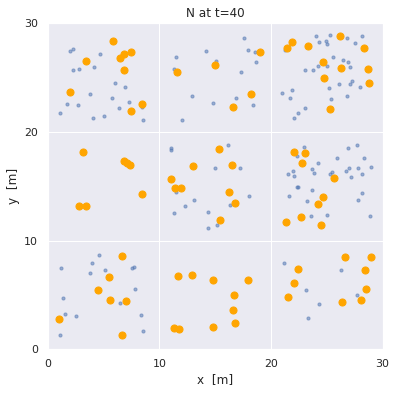

In [5]:
fig = plot_scatter_time(N,t=40,
    sizes = [10,50],
    color = ['b','orange'],
    buffer  = [0.9,0.8],
    alpha   = [0.5,1],
    dx=dx,dy=dy)

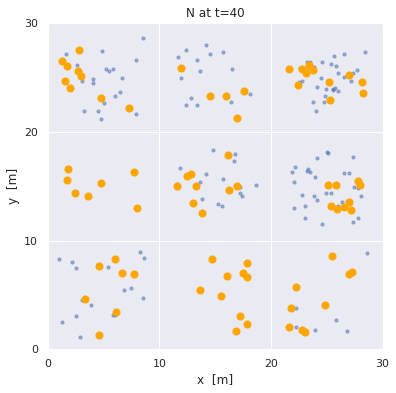

In [7]:
fig = plot_scatter_time(N,t=40,
    sizes = [10,50],
    color = ['b','orange'],
    buffer  = [0.9,0.8],
    alpha   = [0.5,1],
    dx = dx, dy=dy,
    time_tracking=True)

In [8]:
# In case I forget again: ffmpeg -r 10 -i N_movie__dt%03d.png pred_pray_function_check.mp4

plot_scatter_movie(N,0,200,sizes = [10,50],
    color = ['b','orange'],
    buffer  = [0.9,0.8],
    alpha   = [0.5,1],dx = dx,dy=dy)



saved: mov/N_movie__dt000.png
saved: mov/N_movie__dt001.png
saved: mov/N_movie__dt002.png
saved: mov/N_movie__dt003.png
saved: mov/N_movie__dt004.png
saved: mov/N_movie__dt005.png
saved: mov/N_movie__dt006.png
saved: mov/N_movie__dt007.png
saved: mov/N_movie__dt008.png
saved: mov/N_movie__dt009.png
saved: mov/N_movie__dt010.png
saved: mov/N_movie__dt011.png
saved: mov/N_movie__dt012.png
saved: mov/N_movie__dt013.png
saved: mov/N_movie__dt014.png
saved: mov/N_movie__dt015.png
saved: mov/N_movie__dt016.png
saved: mov/N_movie__dt017.png
saved: mov/N_movie__dt018.png
saved: mov/N_movie__dt019.png
saved: mov/N_movie__dt020.png
saved: mov/N_movie__dt021.png
saved: mov/N_movie__dt022.png
saved: mov/N_movie__dt023.png
saved: mov/N_movie__dt024.png
saved: mov/N_movie__dt025.png
saved: mov/N_movie__dt026.png
saved: mov/N_movie__dt027.png
saved: mov/N_movie__dt028.png
saved: mov/N_movie__dt029.png
saved: mov/N_movie__dt030.png
saved: mov/N_movie__dt031.png
saved: mov/N_movie__dt032.png
saved: mov

# lets try some timeline plots

In [9]:
N_over_time = np.sum(N,axis=4)
N_over_time_total = np.sum(N_over_time,axis=0)
N_over_time_total = np.sum(N_over_time_total,axis=0)


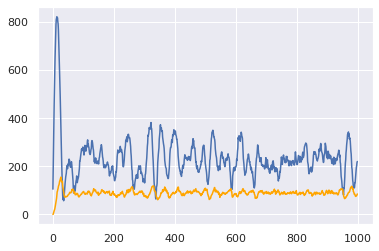

In [10]:
plt.plot(N_over_time_total[0],'b')
plt.plot(N_over_time_total[1],'orange')

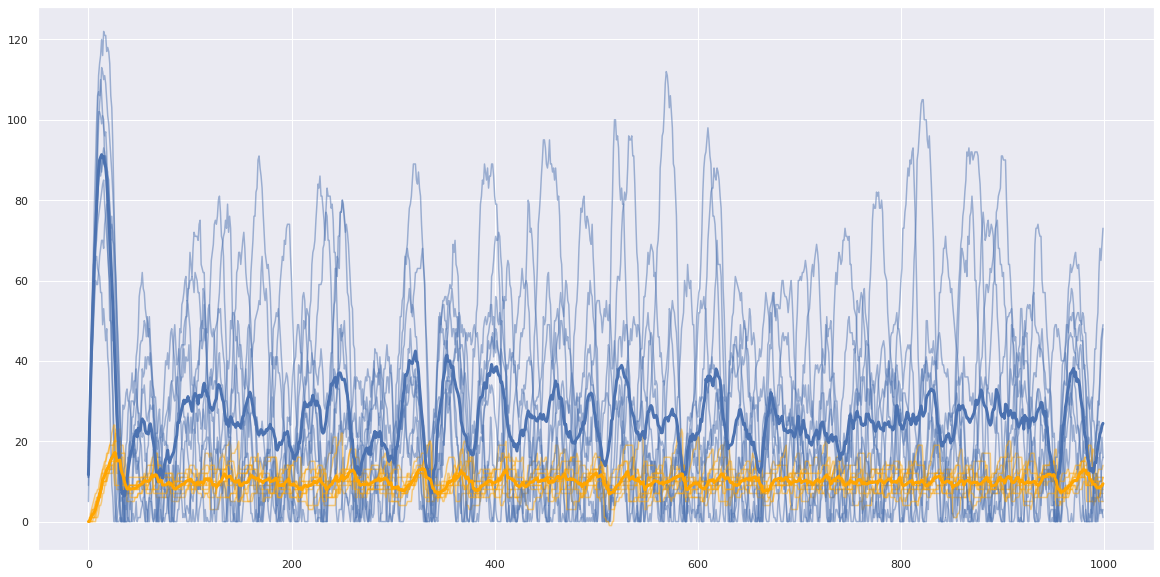

In [11]:
fig,axes = plt.subplots(1,1,figsize=(20,10))

for i in range(nx):
    for j in range(ny):
        axes.plot(N_over_time[i,j,0],'b',alpha=0.5)
        axes.plot(N_over_time[i,j,1],'orange',alpha=0.5)
plt.plot(N_over_time_total[0]/9,'b',linewidth=3)
plt.plot(N_over_time_total[1]/9,'orange',linewidth=3)

# lets look at age distribution 

in theory each animal can reach 100, 

not really sure why there are positive slopes here though, that doesn't make sense to me

In [12]:
N_by_age = np.sum(N,axis=3)
N_by_age = np.sum(N_by_age,axis=0)
N_by_age = np.sum(N_by_age,axis=0)


Text(0, 0.5, 'number')

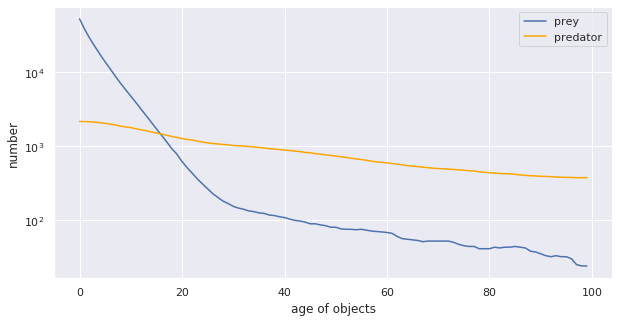

In [13]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(N_by_age[0,:],'b',label='prey')
ax.plot(N_by_age[1,:],'orange',label='predator')
plt.legend()
ax.set_yscale('log')
ax.set_xlabel('age of objects')
ax.set_ylabel('number')

In [42]:
fig.savefig('pics/age_of_pred_pray.pdf',bbox_inches='tight')